# Bonus-track Assignment 2: Custom Python implementation

Implement the Echo State Network as a custom TensorFlow/Keras or PyTorch model. Pay attention to the efficiency of the implementation (e.g., you don’t need to re-calculate the states you have already computed). Consider the possibility of using scikit-learn models for the readout. Solve the previous (and following) problems with the custom python code obtained in this way.

## Libraries

In [5]:
from torch import vstack
import pandas as pd

# To work with Google colab
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Utils/utils.py
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/LAB3_2/Assignment3/TorchEchoStateNetworks.py

from Utils.utils import make_sequence, show_result
from LAB3_2.Assignment3.TorchEchoStateNetworks import SGD_Seq2Seq

## Retrieve the datasets

In [6]:
# To work with Google colab
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Sources/NARMA10.csv
#!wget https://raw.githubusercontent.com/jacons/Computational-NeuroScience-Lab/master/Sources/MG17.csv
source1 = pd.read_csv("./../../Sources/NARMA10.csv", header=None).T.to_numpy()
source2 = pd.read_csv("./../../Sources/MG17.csv", header=None).T.to_numpy()

## NARMA10

In [7]:
tr_dataset = make_sequence(source1[:4000], 1, "NARMA10", expand_dim=1)
dev_dataset = make_sequence(source1[4000:5000], 1, "NARMA10", expand_dim=1)
ts_dataset = make_sequence(source1[5000:], 1, "NARMA10", expand_dim=1)

Train Error 0.010707
Test Error 0.010408


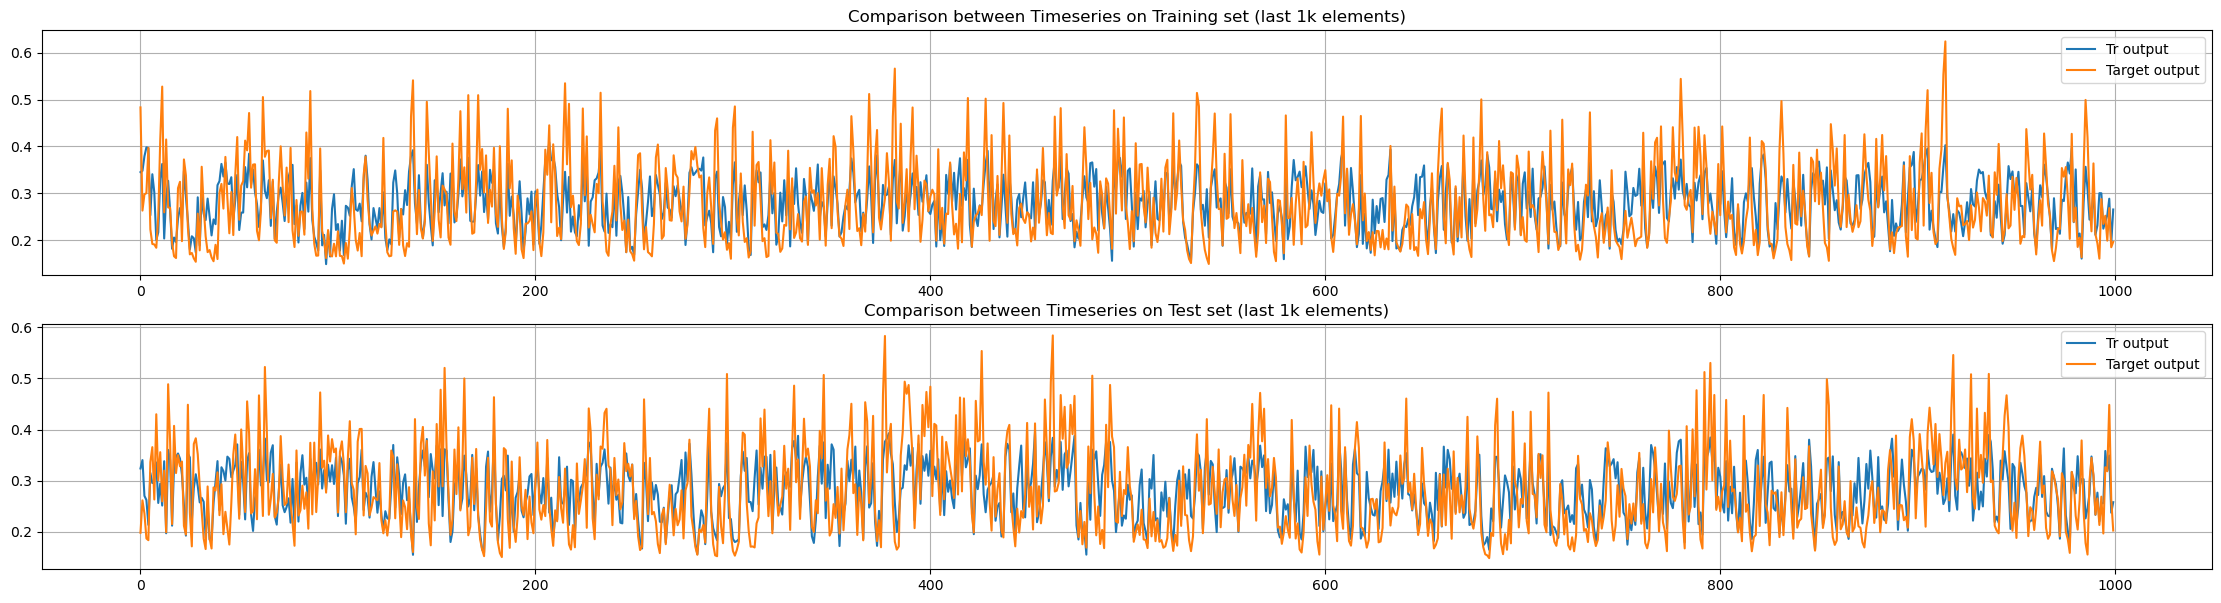

In [8]:
regressor = SGD_Seq2Seq(1, 150, 0.5, 0.9, 0.001, 10000)
regressor.fit(*tr_dataset, transient=100)

tr_dataset = tuple(vstack((x, y)) for x, y in zip(tr_dataset, dev_dataset))
tr_loss, h_last, tr_pred = regressor.predict(*tr_dataset)
print("Train Error", round(tr_loss.item(), 6))

ts_loss, _, ts_pred = regressor.predict(*ts_dataset, h_last)
print("Test Error", round(ts_loss.item(), 6))

show_result(tr_pred, tr_dataset[1], ts_pred, ts_dataset[1])

## Mackey-Glass 17

In [9]:
tr_dataset = make_sequence(source2[:4000], 1, "MG17", expand_dim=1)
dev_dataset = make_sequence(source2[4000:5000], 1, "MG17", expand_dim=1)
ts_dataset = make_sequence(source2[5000:], 1, "MG17", expand_dim=1)

Train Error 0.093639
Test Error 0.093041


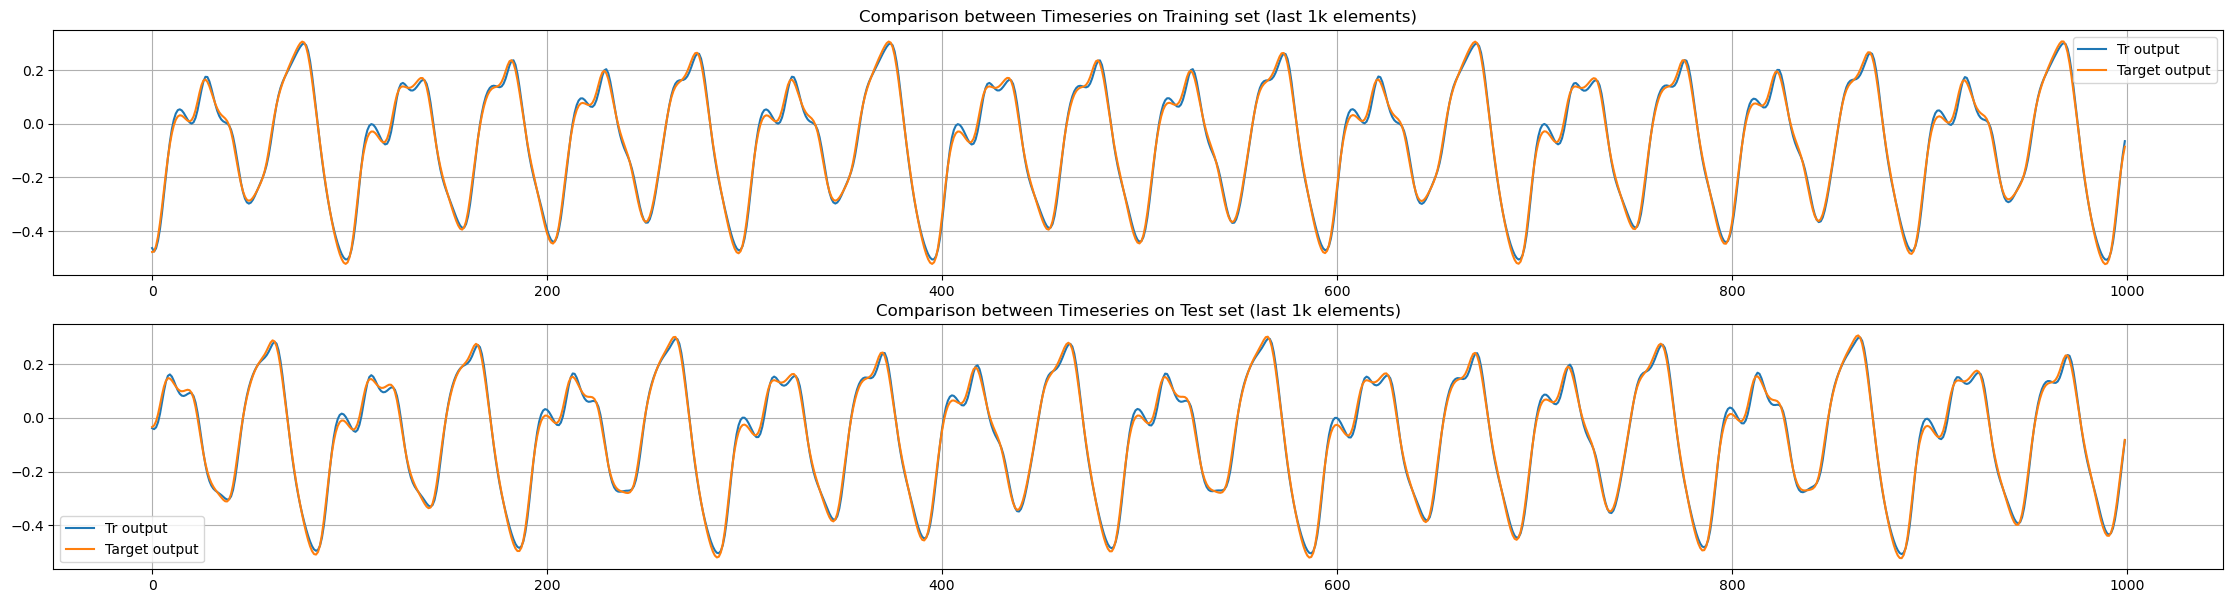

In [10]:
regressor = SGD_Seq2Seq(1, 150, 0.5, 0.9, 0.001, 10000)
regressor.fit(*tr_dataset, transient=100)

tr_dataset = tuple(vstack((x, y)) for x, y in zip(tr_dataset, dev_dataset))
tr_loss, h_last, tr_pred = regressor.predict(*tr_dataset)
print("Train Error", round(tr_loss.item(), 6))

ts_loss, _, ts_pred = regressor.predict(*ts_dataset, h_last)
print("Test Error", round(ts_loss.item(), 6))

show_result(tr_pred, tr_dataset[1], ts_pred, ts_dataset[1])